In [27]:
infrastructures = {
  'education': [
    {
      'name':'kindergarten',
      'tags': {'amenity':'kindergarten'}
    }, 
    {
      'name':'school',
      'tags':{'amenity':'school'}
    }
  ],
  'culture': [
    {
      'name':'museum', 
      'tags':{'tourism':'museum'}
    }, 
    {
      'name':'theatre', 
      'tags':{'amenity':'theatre'}
    }
  ],
  'sport': [
    {
      'name':'pitch',
      'tags':{'leisure':'pitch'}
    }
  ],
  'tourism': [
    {
      'name':'hotel',
      'tags':{'tourism':'hotel'}
    }
  ],
  'healthcare': [
    {
      'name':'polyclinic',
      'tags':{'amenity':'clinic'}
    }, 
    {
      'name':'hospital',
      'tags':{'amenity':'hospital'}
    }
  ]
}

In [28]:
import pandas as pd
import geopandas as gpd

towns = gpd.read_parquet('data/_towns.parquet')
okrugs = gpd.read_parquet('data/_okrugs.parquet')
rayons = gpd.read_parquet('data/_rayons.parquet')
adj_mx = pd.read_pickle('data/_adj_mx.pickle')

In [29]:
from townsnet.models.region import Region

region = Region(
  towns=towns,
  okrugs=okrugs, 
  rayons=rayons, 
  adjacency_matrix=adj_mx
)

In [30]:
for infrastructure, service_types in infrastructures.items():
  for st_dict in service_types:
    service_type_name = st_dict['name']
    gdf = gpd.read_parquet(f'data/_services_{service_type_name}.parquet')
    region.update_capacities(service_type_name, gdf)

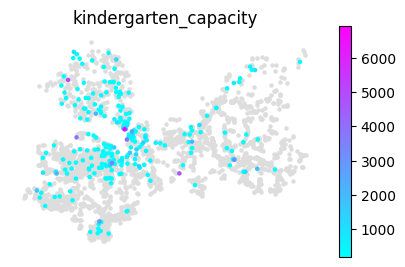

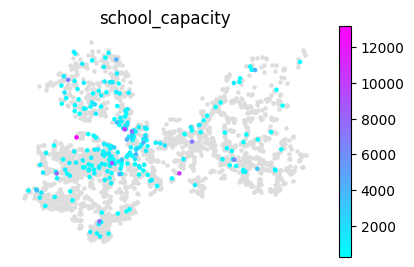

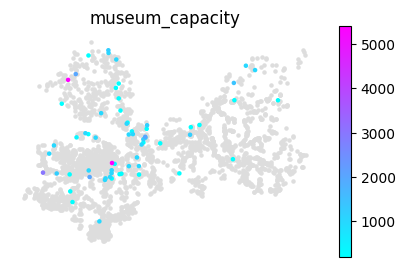

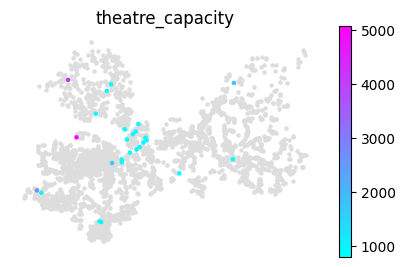

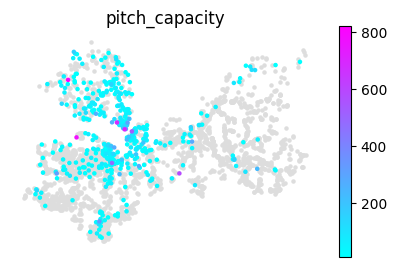

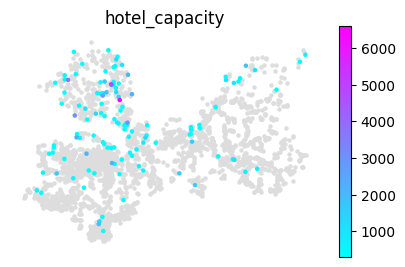

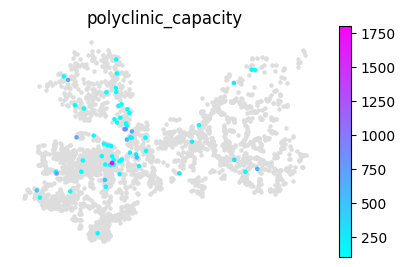

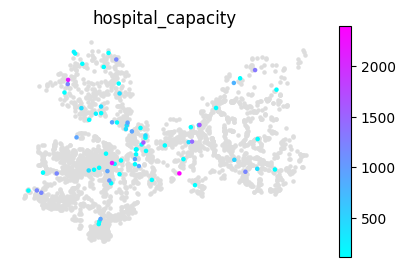

In [31]:
region_gdf = region.to_gdf()
columns = filter(lambda x : x.find('_capacity')>=0,region_gdf.columns)
for column_name in columns:
  ax = region_gdf.loc[region_gdf[column_name]>0].sort_values(by=column_name).plot(
    column=column_name, 
    cmap='cool', 
    legend=True,
    markersize=5,
    figsize=(5,3)
  )
  region_gdf.loc[region_gdf[column_name]==0].plot(color='#ddd', zorder=0, ax=ax, markersize=5)
  ax.set_axis_off()
  ax.set_title(column_name)

In [32]:
from townsnet.method.provision import Provision, ProvisionMethod

prov = Provision(region=region)
prov_dict = {}

for infrastructure, service_types in infrastructures.items():
  for st_dict in service_types:
    service_type_name = st_dict['name']
    prov_dict[service_type_name] = prov.calculate(service_type_name, method=ProvisionMethod.GRAVITATIONAL)

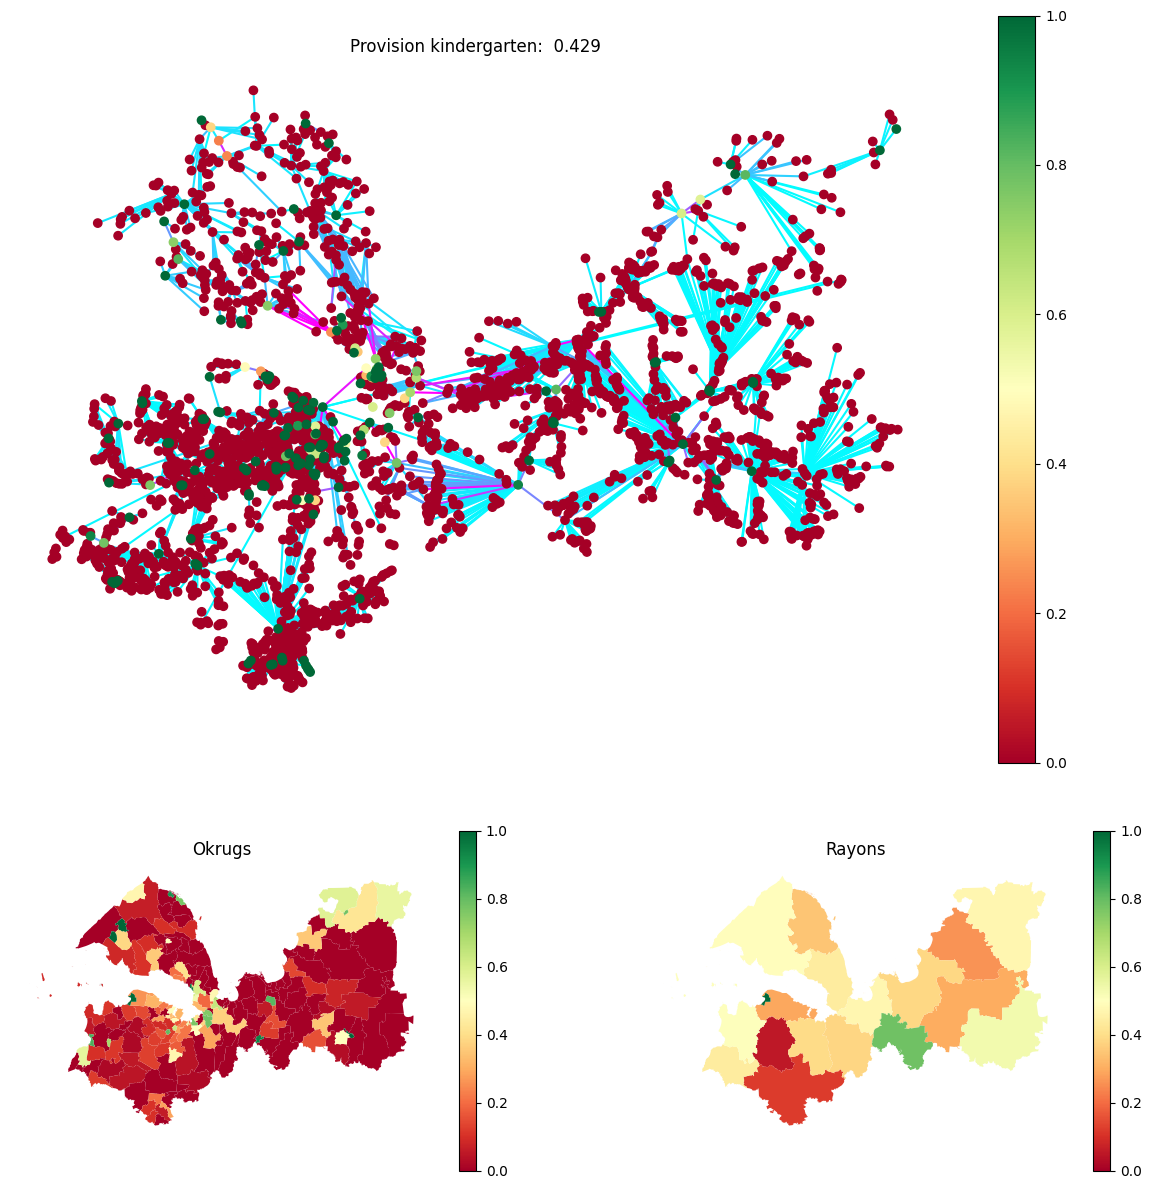

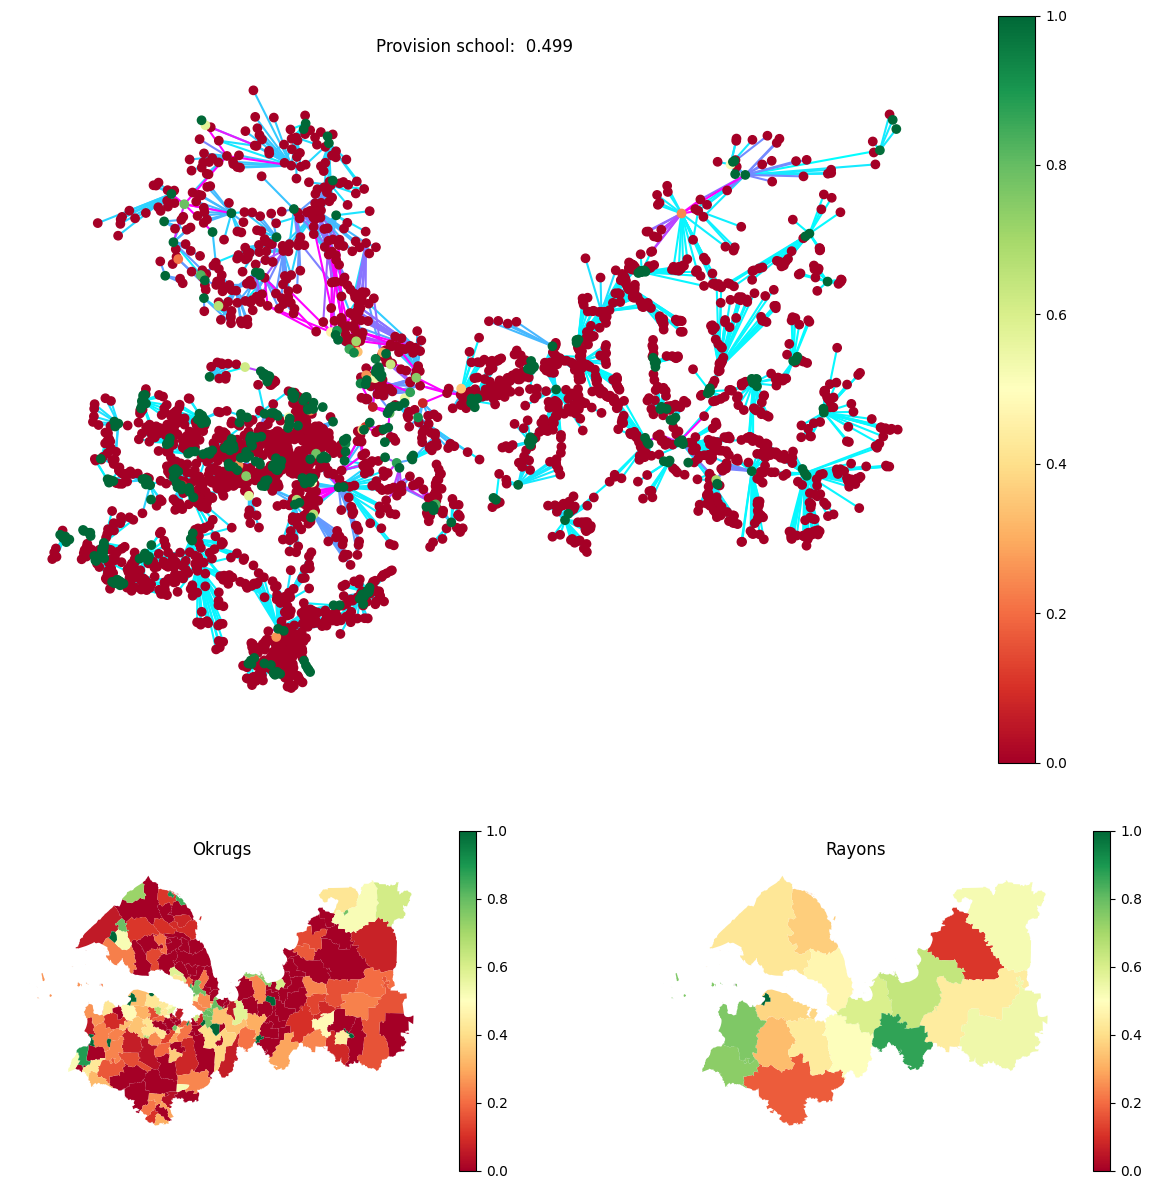

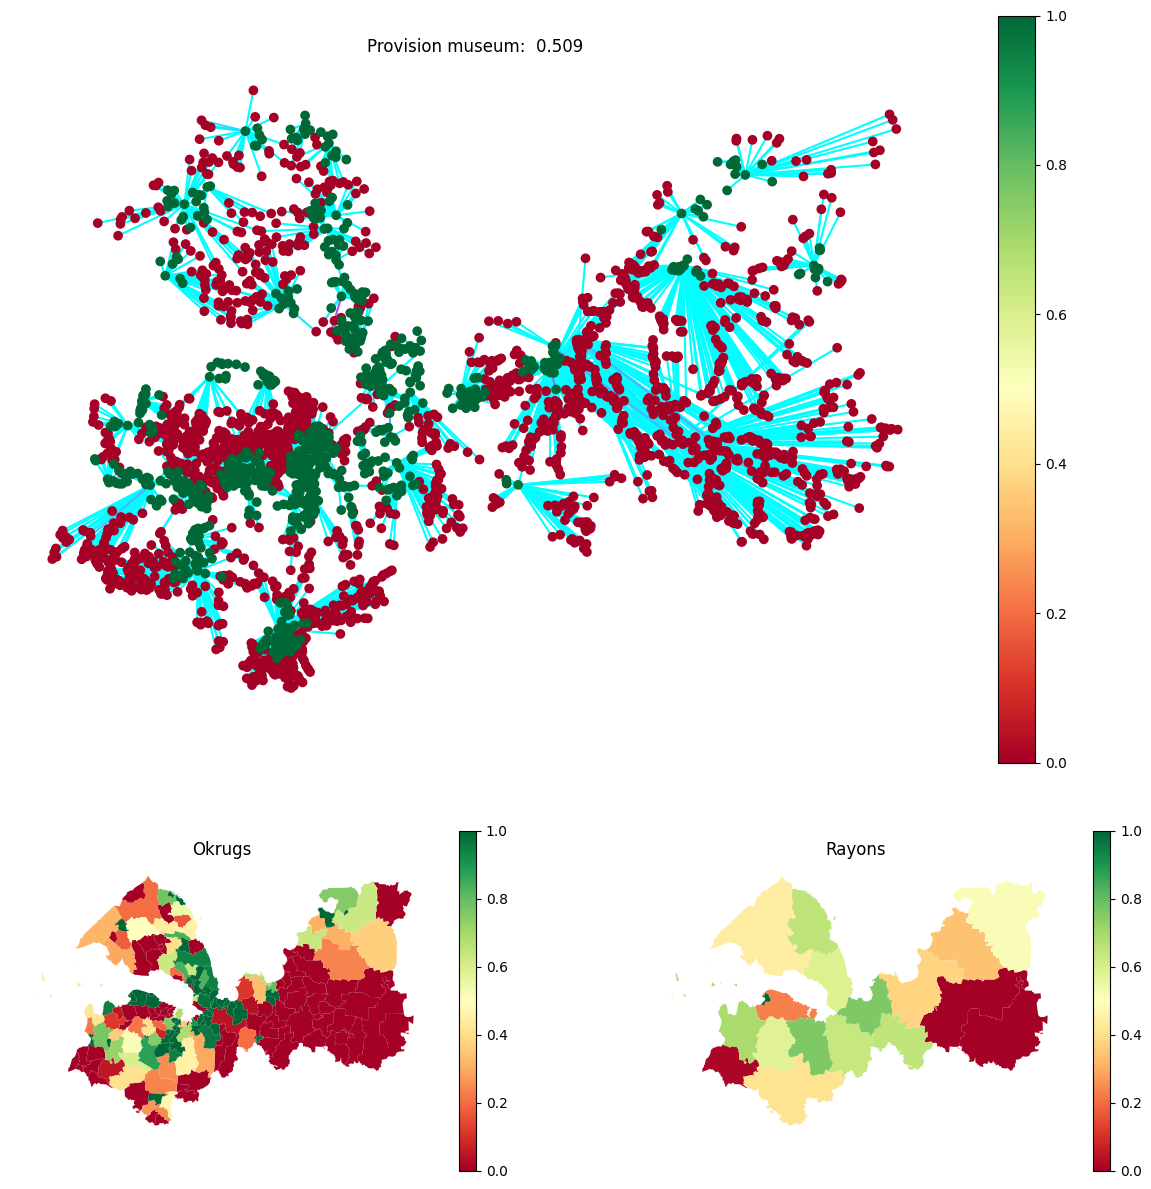

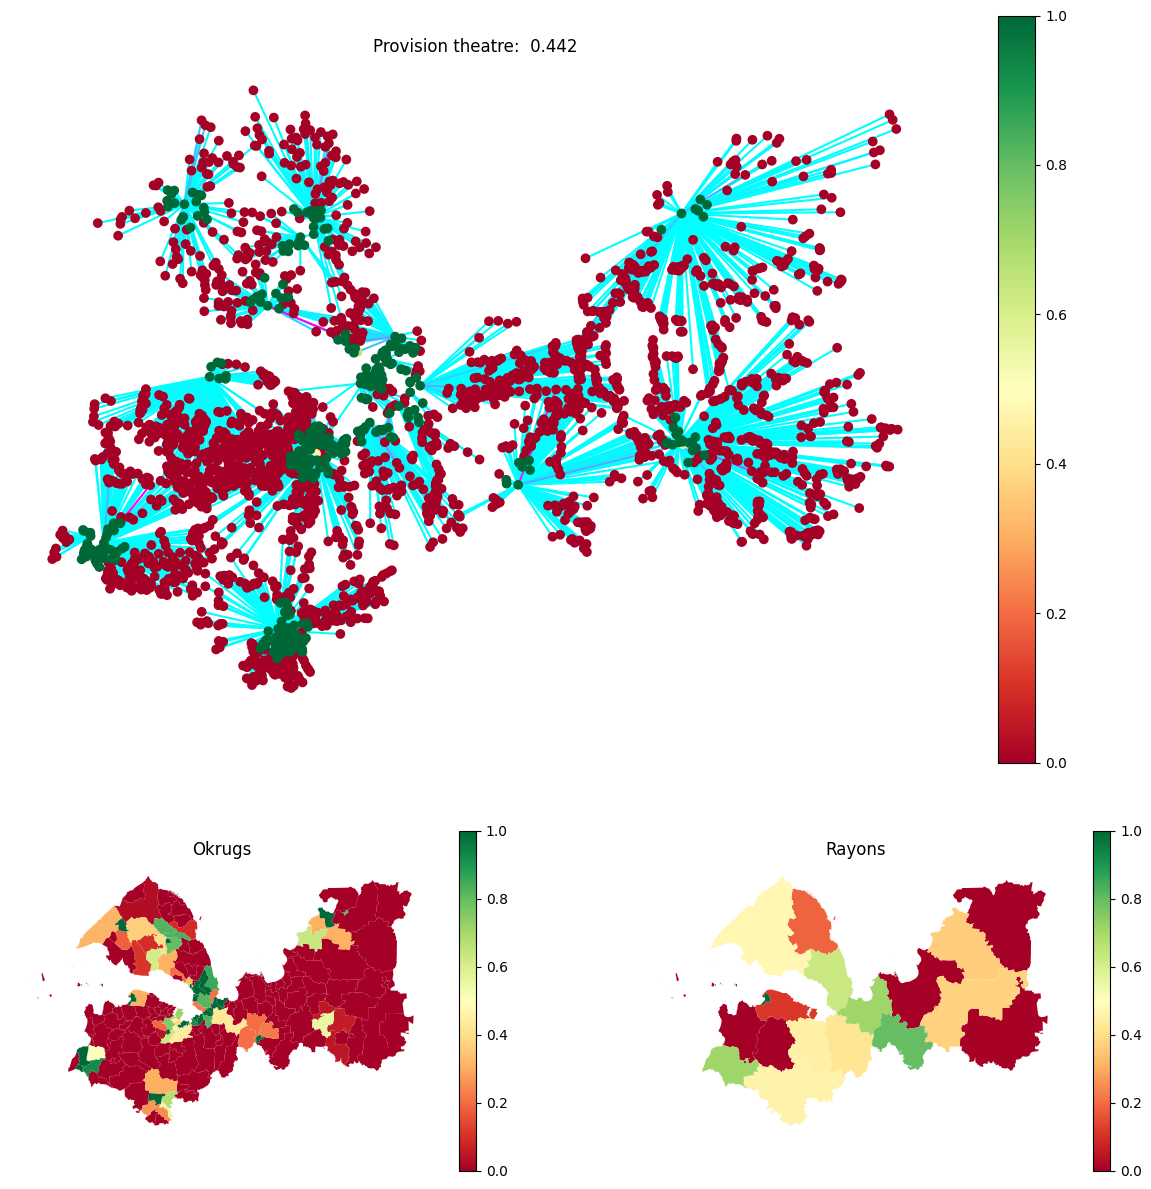

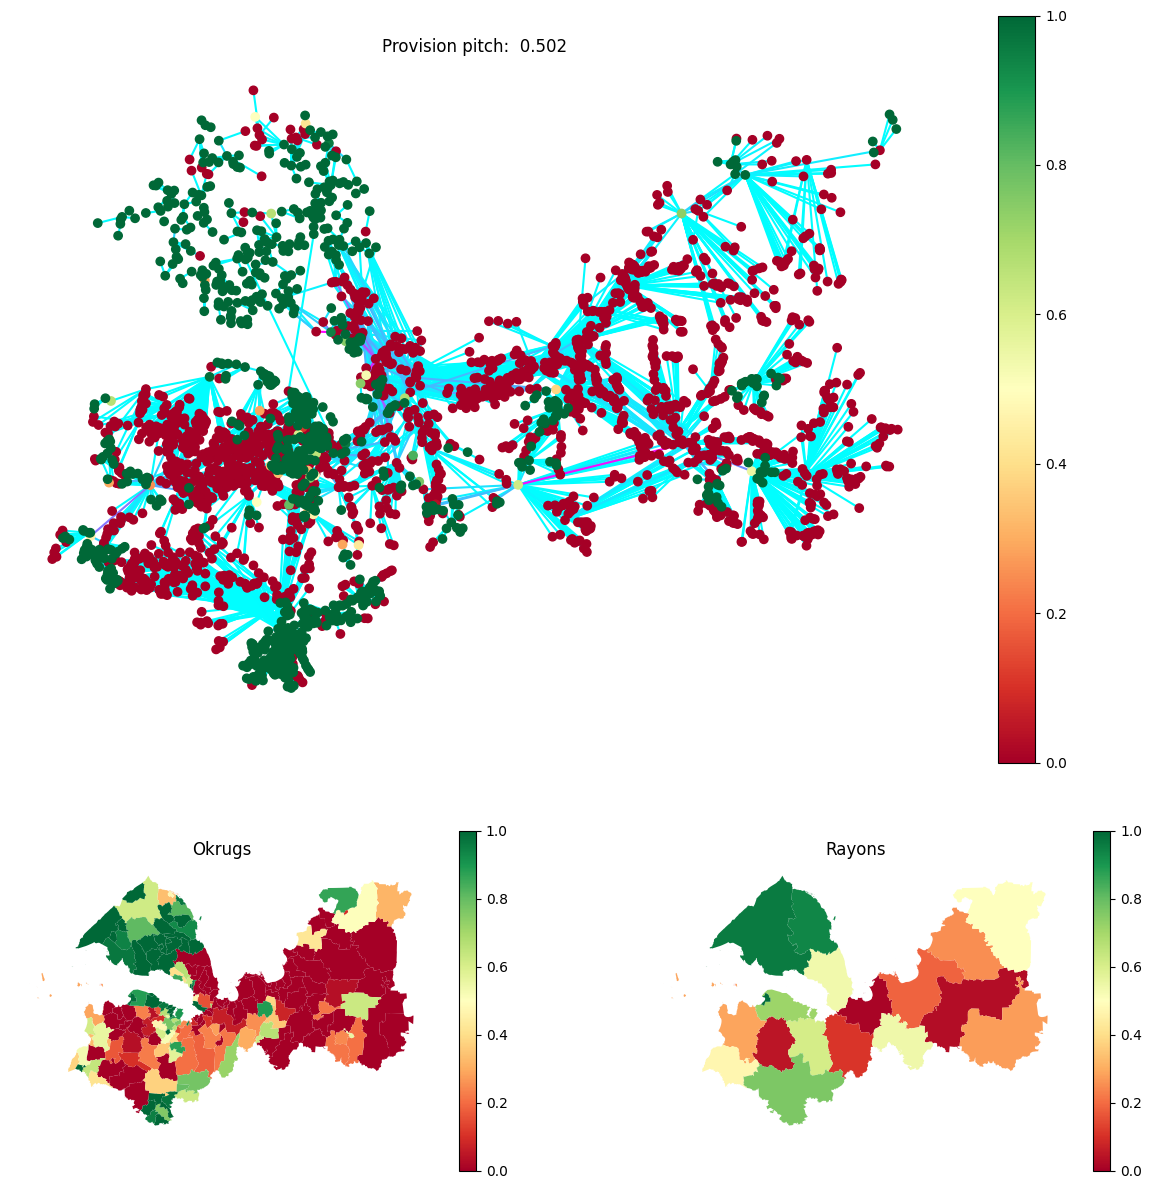

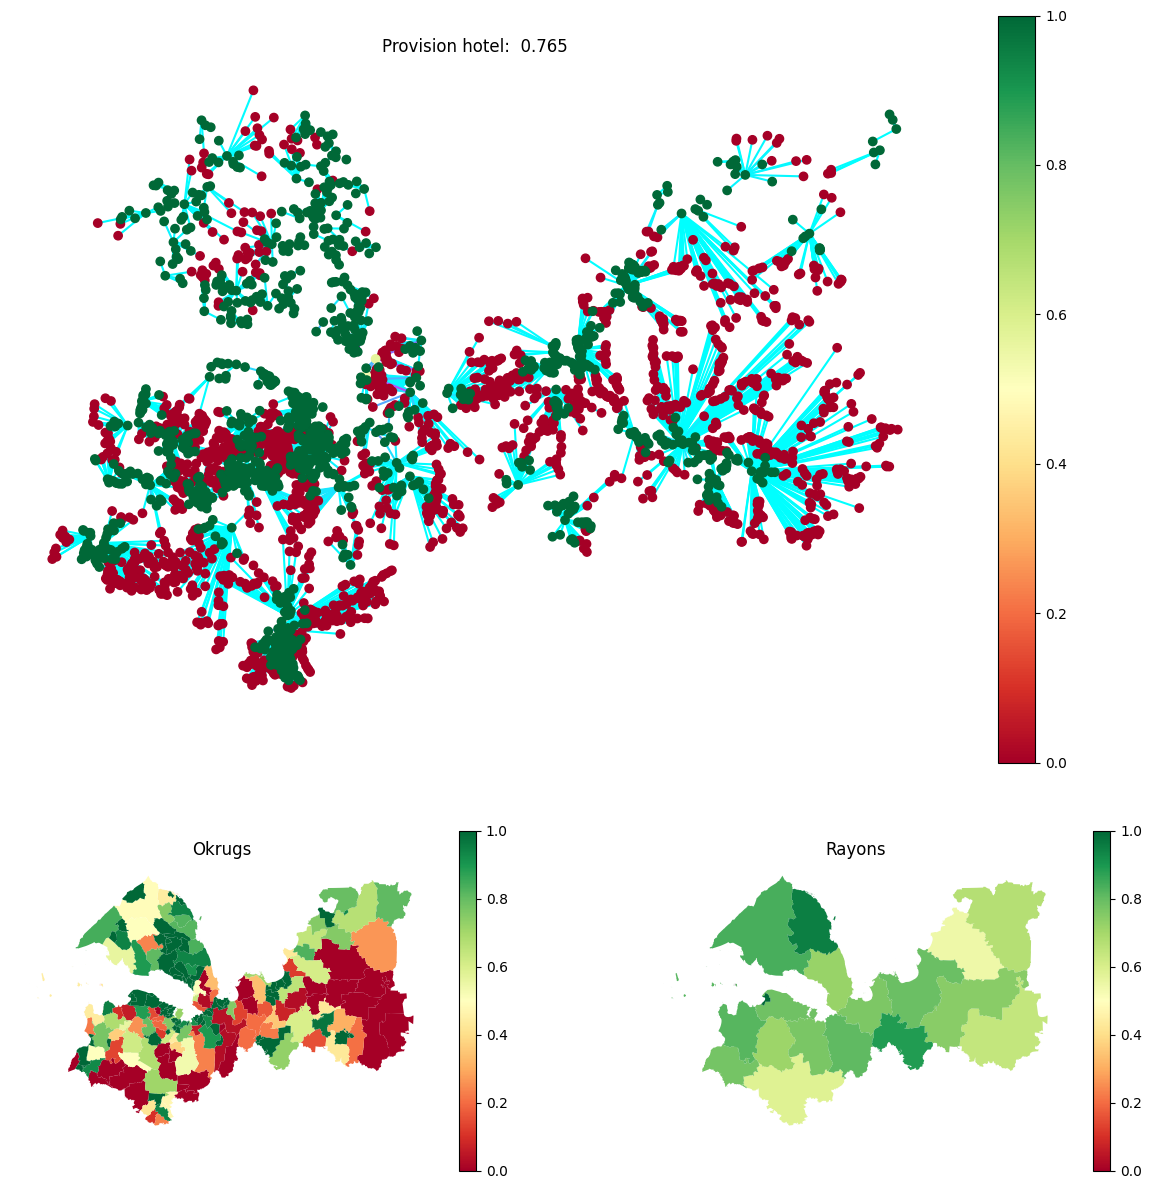

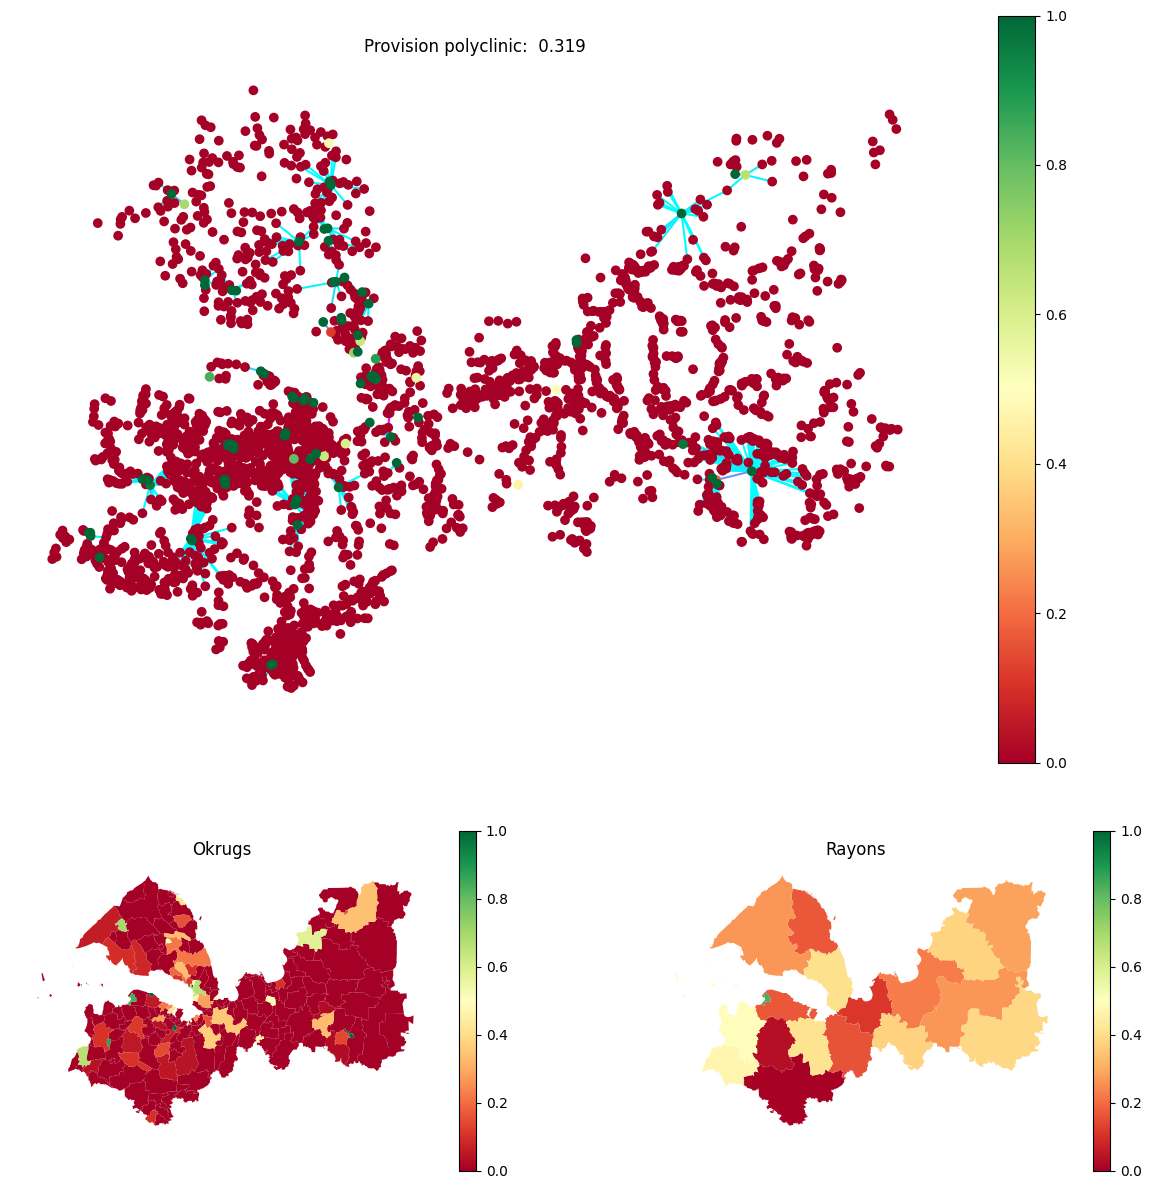

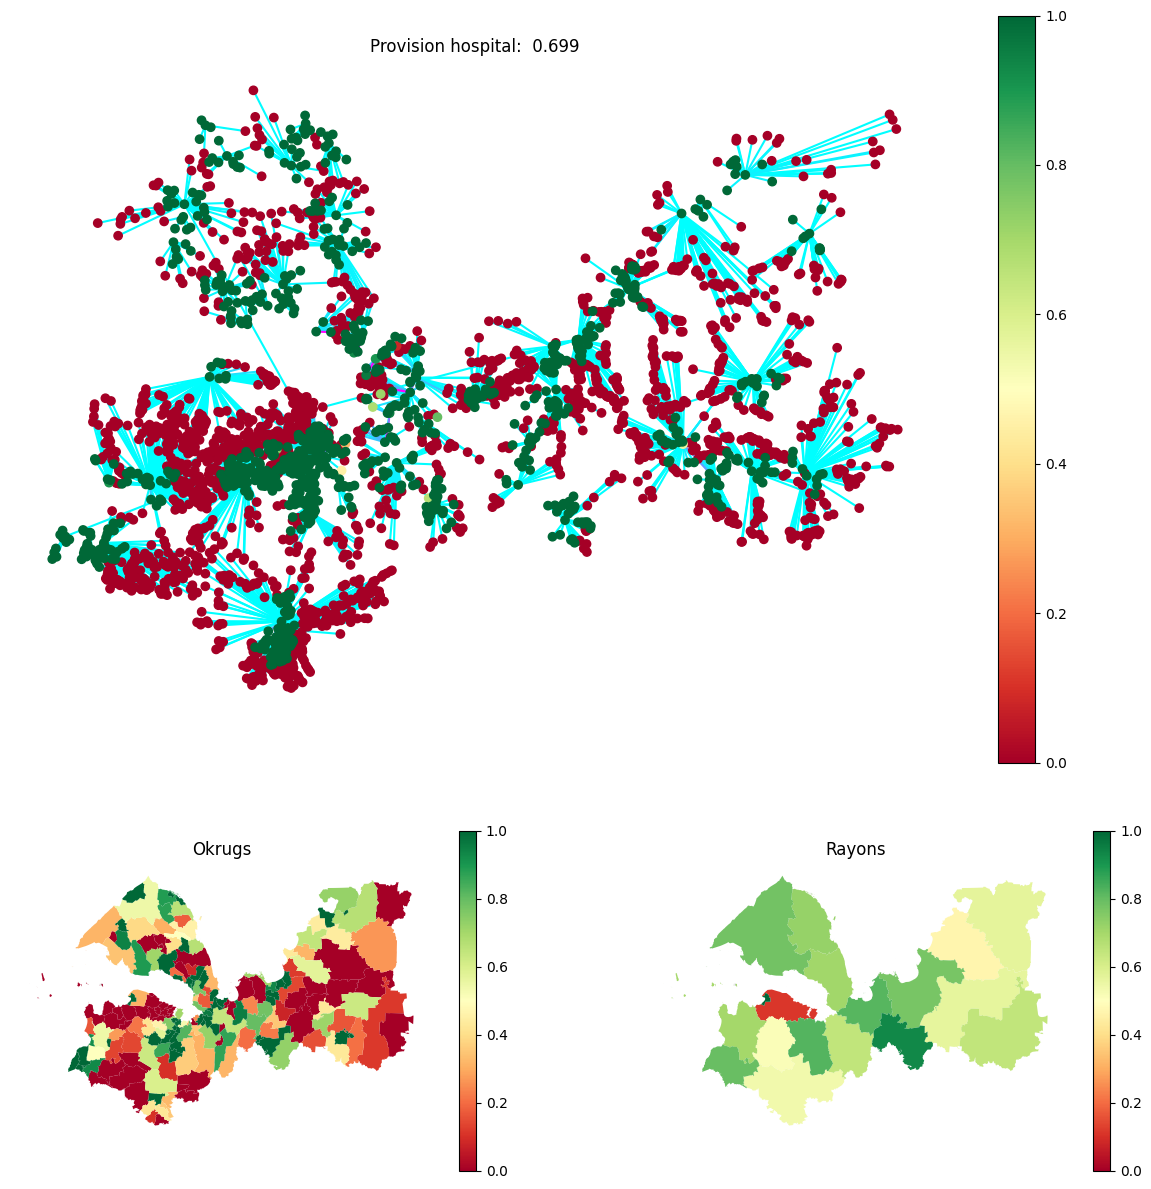

In [33]:
from townsnet.models.service_type import ServiceType
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# def plot(self, service_type, prov_gdf: gpd.GeoDataFrame, weights_gdf : gpd.GeoDataFrame, figsize=(15,15)):
#         """Visualizes provision assessment results"""
#         if not isinstance(service_type, ServiceType):
#             service_type = self.region[service_type]
#         fig = plt.figure(figsize=figsize)
#         grid = GridSpec(3,2)
#         axes = {
#             'towns': fig.add_subplot(grid[0:2,0:2]),
#             'okrugs': fig.add_subplot(grid[2,0]),
#             'rayons': fig.add_subplot(grid[2,1]) 
#         }
#         for ax in axes.values():
#             ax.set_axis_off()
#         okrugs_gdf, rayons_gdf = self.aggregate_units(prov_gdf)
#         self._plot_towns(axes['towns'], service_type, prov_gdf, weights_gdf)
#         self._plot_okrugs(axes['okrugs'], okrugs_gdf)
#         self._plot_rayons(axes['rayons'], rayons_gdf)  

for service_type_name, res_dict in prov_dict.items():
  prov.plot(service_type_name, res_dict[0], res_dict[1]) 